In [1]:
import os
import sqlalchemy as sql

from impyute.imputations.cs import em
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (8, 5)
data_dir = 'data'
img_dir = 'img'
np.random.seed(0)

engine = sql.create_engine('sqlite:///' + data_dir + '/experiment.sqlite')
experiment = pd.read_sql_table('results', engine)
experiment = experiment.set_index(
    ['eweight', 'frac', 'generation', 'size', 'strat', 'task', 'trial']
)
experiment = (experiment
              .loc[experiment.category=='nothing']
              .join(experiment, lsuffix='_base')
              .reset_index()
)
experiment['df_score'] = experiment.score - experiment.score_base
experiment['df_x'] = experiment.coef_x - experiment.coef_x_base
experiment['df_y'] = experiment.coef_y - experiment.coef_y_base
experiment.drop(['category_base'], axis=1, inplace=True)
experiment['log_size'] = experiment['size'].apply(np.log10)

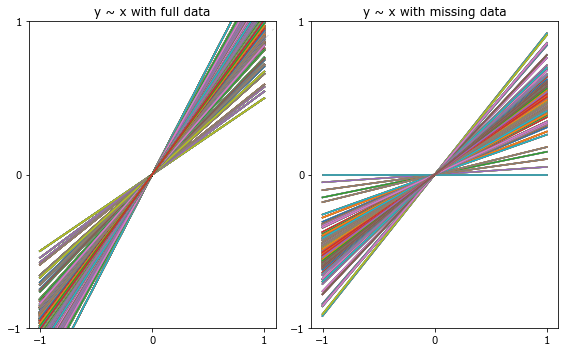

In [2]:
x = np.linspace(-1, 1, 10)
fig, grid = plt.subplots(1, 2)
df = experiment.loc[(experiment.eweight==0.5) & (experiment.frac==0.7) 
                    & (experiment.task=='Lasso') & (experiment.generation=='linear_data')]
for ix, row in df.loc[df.category=='nothing'].iterrows():
    grid[0].plot(x, row['coef_x'] * x)
for ix, row in df.loc[(df.category=='mar') & (df.strat=='listwise_del')].iterrows():
    grid[1].plot(x, row['coef_x'] * x)
for ax in grid:
    ax.set_ylim(-1, 1)
    ax.set_xticks(range(-1, 2, 1))
    ax.set_yticks(range(-1, 2, 1))
grid[0].set_title("y ~ x with full data")
grid[1].set_title("y ~ x with missing data")
fig.tight_layout()
fig.savefig(os.path.join(img_dir, 'prediction_lines.png'))

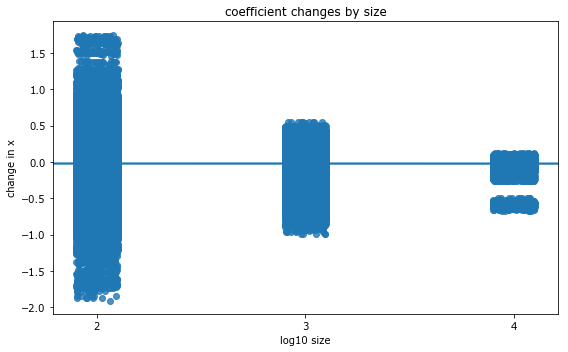

In [3]:
ax = sns.regplot(x='log_size', y='df_x', 
                 data=experiment.loc[experiment.strat=='mean_imputer'], x_jitter=0.1)
ax.set_xlabel('log10 size')
ax.set_ylabel('change in x')
ax.set_xticks(range(2, 5))
ax.set_title("coefficient changes by size")
ax.figure.tight_layout()
ax.figure.savefig(os.path.join(img_dir, 'df_x_by_size.png'))

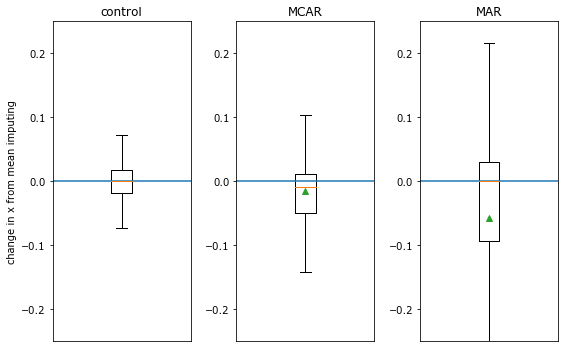

In [4]:
fig, grid = plt.subplots(1, 3)
df = experiment
grid[0].boxplot(df.loc[(df.category=='nothing'), 'df_x'].values, sym='')
grid[1].boxplot(df.loc[(df.category=='mcar') & (df.strat=='mean_imputer'), 'df_x'].values, sym='', showmeans=True)
grid[2].boxplot(df.loc[(df.category=='mar') & (df.strat=='mean_imputer'), 'df_x'].values, sym='', showmeans=True)
for ax, title in zip(grid, ['control', 'MCAR', 'MAR']):
    ax.set_ylim(-0.25, 0.25)
    ax.axhline(0, xmin=0, xmax=1)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_title(title)
grid[0].set_ylabel("change in x from mean imputing")
fig.tight_layout()
fig.savefig(os.path.join(img_dir, 'mean_imputing_missing.png'))

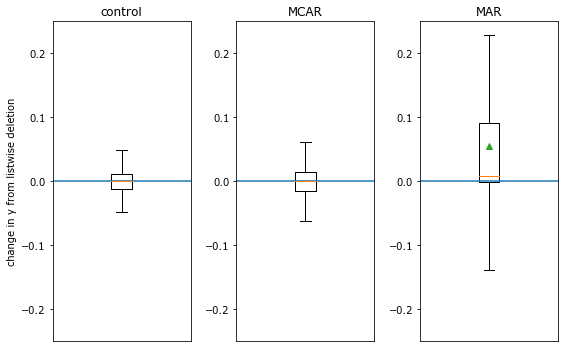

In [5]:
fig, grid = plt.subplots(1, 3)
df = experiment
grid[0].boxplot(df.loc[(df.category=='nothing'), 'df_y'].values, sym='')
grid[1].boxplot(df.loc[(df.category=='mcar') & (df.strat=='listwise_del'), 'df_y'].values, sym='')
grid[2].boxplot(df.loc[(df.category=='mar') & (df.strat=='listwise_del'), 'df_y'].values, sym='', showmeans=True)
for ax, title in zip(grid, ['control', 'MCAR', 'MAR']):
    ax.axhline(0, xmin=0, xmax=1)
    ax.set_ylim(-.25, .25)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(title)
grid[0].set_ylabel("change in y from listwise deletion")
fig.tight_layout()
fig.savefig(os.path.join(img_dir, 'listwise_del_missing.png'))

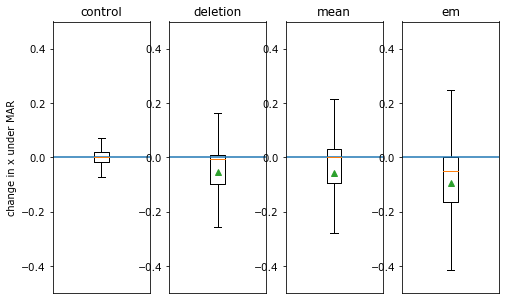

In [6]:
fig, grid = plt.subplots(1, 4)
df = experiment
grid[0].boxplot(df.loc[(df.category=='nothing'), 'df_x'].values, sym='')
grid[1].boxplot(df.loc[(df.category=='mar') & (df.strat=='listwise_del'), 'df_x'].values, sym='', showmeans=True)
grid[2].boxplot(df.loc[(df.category=='mar') & (df.strat=='mean_imputer'), 'df_x'].values, sym='', showmeans=True)
grid[3].boxplot(df.loc[(df.category=='mar') & (df.strat=='em_imputer'), 'df_x'].values, sym='', showmeans=True)
for ax, title in zip(grid, ['control', 'deletion', 'mean', 'em']):
    ax.set_ylim(-.5, .5)
    ax.axhline(0, xmin=0, xmax=1)
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(title)
grid[0].set_ylabel("change in x under MAR")
fig.savefig(os.path.join(img_dir, 'em_missing.png'))

In [7]:
df = experiment
print('tests for differences in the coefficient of x')
row = "| {:<8.8} | {:<13.13} | {:<8.8} | {:<8.8} |"
print(row.format('regime', 'strategy', 't', 'p'))
for regime in ["mcar", "mar", "mnar"]:
    for strategy in ['listwise_del', 'mean_imputer', 'em_imputer']:
        result = stats.ttest_ind(
            a=df.loc[df.category=='nothing', 'coef_x'], 
            b=df.loc[(df.category==regime) & (df.strat==strategy), 'coef_x'], 
            equal_var=False, nan_policy='omit')
        print(row.format(regime, strategy, round(result.statistic, 3), round(result.pvalue, 3)))

tests for differences in the coefficient of x
| regime   | strategy      | t        | p        |
| mcar     | listwise_del  | 0.389    | 0.697    |
| mcar     | mean_imputer  | 7.684    | 0.0      |
| mcar     | em_imputer    | 12.336   | 0.0      |
| mar      | listwise_del  | 27.859   | 0.0      |
| mar      | mean_imputer  | 28.509   | 0.0      |
| mar      | em_imputer    | 48.919   | 0.0      |
| mnar     | listwise_del  | 0.331    | 0.741    |
| mnar     | mean_imputer  | 9.535    | 0.0      |
| mnar     | em_imputer    | 36.687   | 0.0      |


In [8]:
print('tests for differences in the coefficient of y')
row = "| {:<8.8} | {:<13.13} | {:<8.8} | {:<8.8} |"
print(row.format('regime', 'strategy', 't', 'p'))
for regime in ["mcar", "mar", "mnar"]:
    for strategy in ['listwise_del', 'mean_imputer', 'em_imputer']:
        result = stats.ttest_ind(
            a=df.loc[df.category=='nothing', 'coef_y'], 
            b=df.loc[(df.category==regime) & (df.strat==strategy), 'coef_y'], 
            equal_var=False, nan_policy='omit')
        print(row.format(regime, strategy, round(result.statistic, 3), round(result.pvalue, 3)))

tests for differences in the coefficient of y
| regime   | strategy      | t        | p        |
| mcar     | listwise_del  | 0.005    | 0.996    |
| mcar     | mean_imputer  | -2.28    | 0.023    |
| mcar     | em_imputer    | -3.745   | 0.0      |
| mar      | listwise_del  | -29.256  | 0.0      |
| mar      | mean_imputer  | -2.437   | 0.015    |
| mar      | em_imputer    | -2.876   | 0.004    |
| mnar     | listwise_del  | -3.486   | 0.0      |
| mnar     | mean_imputer  | -0.128   | 0.898    |
| mnar     | em_imputer    | 0.072    | 0.943    |


In [9]:
print('tests for differences in the model error')
row = "| {:<8.8} | {:<13.13} | {:<8.8} | {:<8.8} |"
print(row.format('regime', 'strategy', 't', 'p'))
for regime in ["mcar", "mar", "mnar"]:
    for strategy in ['listwise_del', 'mean_imputer', 'em_imputer']:
        result = stats.ttest_ind(
            a=df.loc[df.category=='nothing', 'score'], 
            b=df.loc[(df.category==regime) & (df.strat==strategy), 'score'], 
            equal_var=False, nan_policy='omit')
        print(row.format(regime, strategy, round(result.statistic, 3), round(result.pvalue, 3)))

tests for differences in the model error
| regime   | strategy      | t        | p        |
| mcar     | listwise_del  | -1.332   | 0.183    |
| mcar     | mean_imputer  | -5.643   | 0.0      |
| mcar     | em_imputer    | -7.297   | 0.0      |
| mar      | listwise_del  | -46.945  | 0.0      |
| mar      | mean_imputer  | -54.322  | 0.0      |
| mar      | em_imputer    | -52.646  | 0.0      |
| mnar     | listwise_del  | -9.102   | 0.0      |
| mnar     | mean_imputer  | -12.127  | 0.0      |
| mnar     | em_imputer    | -17.626  | 0.0      |
